<a href="https://colab.research.google.com/github/manfredi31/image-generation/blob/main/02_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation

Below is my implementation of a simple VAE that learns to reconstruct images with the MNIST dataset, based on this [great replication of the VAE and VQ VAE papers by Jackson Kang](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/tree/master).

In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
dataset_path="~/datasets"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dim = 784 # Each image is 28 x 28 = 784 pixels
batch_size = 100
hidden_dim = 400
latent_dim = 200
learning_rate = 1e-3
epochs = 30


In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# MNIST
mnist_transform = transforms.Compose([
    transforms.ToTensor()
])
kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        # Hidden layers used to process the inputs before converting to latents
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
        )

        # Latent representations encoded into mean and log variance vectors
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_variance = nn.Linear(hidden_dim, latent_dim)

        self.training = True

    def forward(self, x):
        hidden = self.hidden(x)
        mean = self.mean(hidden)
        log_variance = self.log_variance(hidden)

        return mean, log_variance

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        # Convert back from the latents to the reconstruction
        self.hidden = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x_hat = torch.sigmoid(self.hidden(x))
        return x_hat

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, variance):
        # Separate out the randomness into the epsilon term
        epsilon = torch.randn_like(variance).to(device)

        # Now gradients can flow back through mean and variance stil
        z = mean + variance * epsilon

        return z

    def forward(self, x):
        mean, log_variance = self.Encoder(x)

        # Use the reparameterization trick to keep randomness differentiable
        z = self.reparameterization(mean, torch.exp(0.5 * log_variance))

        x_hat = self.Decoder(z)
        return x_hat, mean, log_variance

In [ ]:
encoder = Encoder(input_dim=data_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim = data_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [ ]:
from torch.optim import Adam

def bce_loss(x, x_hat, mean, log_variance):
    # reconstruction loss encourages latents to model distribution better
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # kl div penalizes latents from deviating too far from gaussian
    kl_divergence = - 0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

    # both balance each other out to make a good approximation
    return reconstruction_loss + kl_divergence

optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, data_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_variance = model(x)
        loss = bce_loss(x, x_hat, mean, log_variance)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"epoch {epoch + 1}: average loss {overall_loss / (batch_idx*batch_size)}")

epoch 1: average loss 172.74887594232575
epoch 2: average loss 128.2209591995774
epoch 3: average loss 117.5232250365192
epoch 4: average loss 113.37799142777024
epoch 5: average loss 110.49296118530884
epoch 6: average loss 108.71922556474333
epoch 7: average loss 107.27195219571682
epoch 8: average loss 106.2627855833942
epoch 9: average loss 105.38990369691673
epoch 10: average loss 104.8008842700073
epoch 11: average loss 104.23132069073456
epoch 12: average loss 103.82712619991652
epoch 13: average loss 103.361290969976
epoch 14: average loss 102.97277955120514
epoch 15: average loss 102.7324923863992
epoch 16: average loss 102.47972457350792
epoch 17: average loss 102.26439151515547
epoch 18: average loss 101.95725391929257
epoch 19: average loss 101.83075914284224
epoch 20: average loss 101.58246855110079
epoch 21: average loss 101.42813455368322
epoch 22: average loss 101.25648360874895
epoch 23: average loss 101.11317770828985
epoch 24: average loss 101.02827437004382
epoch 25

With the trained model, we can now run images in the original dataset through the model and see how well they get constructed.

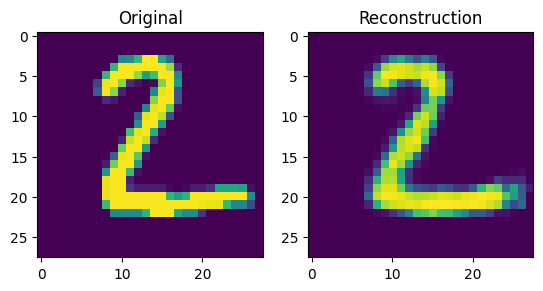

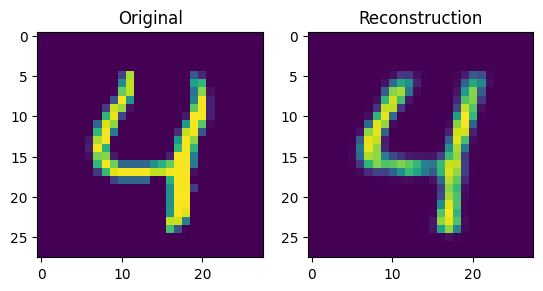

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

model.eval()

def show_image(x, idx, figure=True):
    if figure:
      fig = plt.figure()

    x = x.view(batch_size, 28, 28)
    plt.imshow(x[idx].cpu().numpy())

def show_comparison(x, x_hat, idx):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    show_image(x, idx, False)
    plt.title("Original")
    plt.subplot(1, 2, 2)
    show_image(x_hat, idx, False)
    plt.title("Reconstruction")

x, _ = next(iter(test_loader))
with torch.no_grad():
      x = x.view(batch_size, data_dim)
      x = x.to(device)

      x_hat, _, _ = model(x)

show_comparison(x, x_hat, 1) # digit 2
show_comparison(x, x_hat, 4) # digit 4

Because of how the decoder learns to create images from the latents (and is forced to represent a lot of the complexity), we can actually create generations from random noise with the decoder and yield distinguishable results.

Here, we do this, and I've cherry picked some nice examples (generated from random noise as the latent representations).

In [ ]:
from torchvision.utils import save_image, make_grid

with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = decoder(noise)

save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')


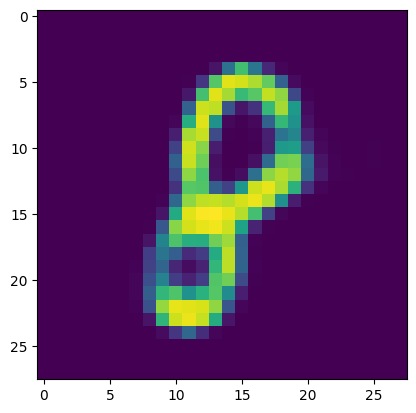

In [ ]:
show_image(generated_images, idx = 6)

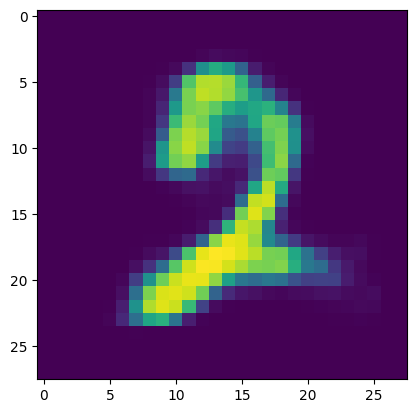

In [ ]:
show_image(generated_images, idx = 7)